<!-- WARNING: THIS FILE WAS AUTOGENERATED! DO NOT EDIT! -->

In [25]:
from icecream import ic
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)
import warnings
from torch.jit import TracerWarning

warnings.filterwarnings("ignore", category=TracerWarning)

In [26]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
g = torch.Generator(device=device).manual_seed(42)

## Attention mechanism
Based on formal algorithm for transformers (https://arxiv.org/abs/2207.09238) where it can be used for different attention architectures like 
- encoder-decoder/seq-to-seq (very first transformer), 
- encoder-only (bert), 
- decoder-only (gpt-*, gopher). 

### Encoder-decoder architecture use 2 sequences as input
- context sequence of tokens (z), which is used to encode context as a vector per token with bidirectional attention
- primary sequence of tokens (x), which is used to decode both the encoded context and a masked primary sequence (tokens in primary sequence that precedes current). This is used to train a translator from FR to EN for instance. FR tokens are the context sequence and EN tokens are the primary sequence (target)
 
### Encoder only architecture use 1 primary sequence as input
Given a primary input sequence (x) with some tokens masked out, the goal is to recover the masked tokens. the goal is to learn a generally usefull representation of text. Uses a bidirectional attention

### Decoder only architecture use 1 primary sequence as input
Autoregressive language modelling where the goal is to predict the next token of a primary token sequence (x). Uses a unidirectional causal (masked) attention. 

## Basic mechanism behind attention
How can we compute a matrix of size TxT (T is nb timesteps or length) to split attention from each token in sequence to only previouse tokens

That matrix would be called attention matrix

In [27]:
torch.manual_seed(42)
B, T, C = 4, 8, 2
x = torch.randn(B, T, C)
x.shape

torch.Size([4, 8, 2])

In [28]:
# 1st method to compute the matrix
wei = torch.tril(torch.ones((T, T)))
ic(wei)
wei = wei / wei.sum(axis=1, keepdim=True)
ic("weight", wei)
xbow = wei @ x  # B,T,C @ B,T,T ---> B,T,C

ic| wei: tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
                 [1., 1., 0., 0., 0., 0., 0., 0.],
                 [1., 1., 1., 0., 0., 0., 0., 0.],
                 [1., 1., 1., 1., 0., 0., 0., 0.],
                 [1., 1., 1., 1., 1., 0., 0., 0.],
                 [1., 1., 1., 1., 1., 1., 0., 0.],
                 [1., 1., 1., 1., 1., 1., 1., 0.],
                 [1., 1., 1., 1., 1., 1., 1., 1.]])
ic| "weight": 'weight'
    wei: tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                 [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                 [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                 [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
                 [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
                 [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
                 [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.14

In [29]:
# method 2 using softmax
tril = torch.tril(torch.ones((T, T)))
ic(tril)
# we can initiate with zeros, ones or any values
wei = torch.zeros((T, T))
#
wei = torch.ones((T, T))
wei = torch.full((T, T), 4.0)

# ic(wei)
wei = wei.masked_fill(tril == 0, value=float("-inf"))
ic(wei)
wei = F.softmax(wei, dim=1)
ic(wei)

xbow2 = wei @ x
torch.allclose(xbow, xbow2)

ic| tril: tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
                  [1., 1., 0., 0., 0., 0., 0., 0.],
                  [1., 1., 1., 0., 0., 0., 0., 0.],
                  [1., 1., 1., 1., 0., 0., 0., 0.],
                  [1., 1., 1., 1., 1., 0., 0., 0.],
                  [1., 1., 1., 1., 1., 1., 0., 0.],
                  [1., 1., 1., 1., 1., 1., 1., 0.],
                  [1., 1., 1., 1., 1., 1., 1., 1.]])
ic| wei: tensor([[4., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
                 [4., 4., -inf, -inf, -inf, -inf, -inf, -inf],
                 [4., 4., 4., -inf, -inf, -inf, -inf, -inf],
                 [4., 4., 4., 4., -inf, -inf, -inf, -inf],
                 [4., 4., 4., 4., 4., -inf, -inf, -inf],
                 [4., 4., 4., 4., 4., 4., -inf, -inf],
                 [4., 4., 4., 4., 4., 4., 4., -inf],
                 [4., 4., 4., 4., 4., 4., 4., 4.]])
ic| wei: tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                 [0.5000, 0.5000, 0

True

### Let put it together

- we project the input (x) to a 
  - query: current element we focus on
  - key: context (other words)
  - value : 
- we compute similarity with dot product between query and key, to capture how similar current element and context are aligned/similar, aka raw attention score
- we mask the score matrix so each query focus only on past tokens (key)
- we normalize the similarity score with a softmax -> it compute the weight each token should put on previous tokens.
- apply the attention matrix (weight) to the value matrix. 

ic| B: 1, T: 8, C: 5
ic| wei.shape: torch.Size([1, 8, 8])
    v.shape: torch.Size([1, 8, 5])
    out.shape: torch.Size([1, 8, 5])
ic| wei[0]: tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                    [0.4967, 0.5033, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                    [0.3345, 0.3286, 0.3369, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
                    [0.2571, 0.2444, 0.2441, 0.2544, 0.0000, 0.0000, 0.0000, 0.0000],
                    [0.1978, 0.1931, 0.2006, 0.2130, 0.1955, 0.0000, 0.0000, 0.0000],
                    [0.1666, 0.1617, 0.1675, 0.1753, 0.1628, 0.1661, 0.0000, 0.0000],
                    [0.1391, 0.1407, 0.1470, 0.1503, 0.1398, 0.1403, 0.1428, 0.0000],
                    [0.1232, 0.1230, 0.1296, 0.1297, 0.1201, 0.1202, 0.1258, 0.1285]],
                   grad_fn=<SelectBackward0>)


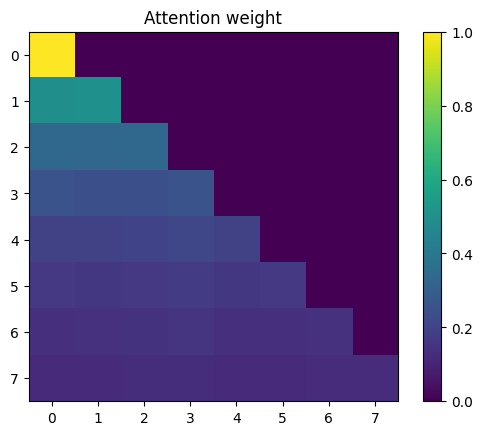

In [30]:
torch.manual_seed(42)
B, T, C = 1, 8, 5
ic(B, T, C)
# the input after token embedding lookup
x = torch.rand(B, T, C)

head_size = 5
key = nn.Linear(C, head_size)
k = key(x)
query = nn.Linear(C, head_size)
q = query(x)
value = nn.Linear(C, head_size)
v = value(x)
# v = torch.full((B,T,C), fill_value=1.)

# dot product as a similarity measure
wei = q @ k.transpose(-2, -1) * head_size**-0.5
tril = torch.tril(torch.ones(T, T))
wei = wei.masked_fill(tril == 0, float("-inf"))
wei = F.softmax(wei, dim=-1)

out = wei @ v
ic(wei.shape, v.shape, out.shape)
ic(wei[0])

plt.imshow(wei[0].detach())
plt.colorbar()
plt.title("Attention weight")
plt.show()


# first token out value should be the same as first value
assert all(out[0][0] == v[0][0])
# then it's no more the case
assert not all(out[0][3] == v[0][3])

## Let write torch modules and functions

In [0]:
#| echo: false
#| output: asis
show_doc(unidirectional_mask)

---

### unidirectional_mask

>      unidirectional_mask (seq_len:int)

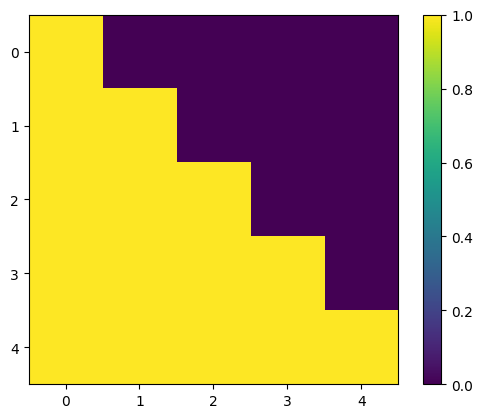

In [32]:
ic.disable()
ic.enable()
mask = unidirectional_mask(5)

plt.imshow(mask[0])
plt.colorbar()

plt.show()

In [0]:
#| echo: false
#| output: asis
show_doc(attention)

---

### attention

>      attention (query:torch.Tensor, key:torch.Tensor, value:torch.Tensor,
>                 mask:Optional[torch.Tensor]=None,
>                 softmax:torch.nn.modules.module.Module=Softmax(dim=-1),
>                 dropout:Optional[torch.nn.modules.module.Module]=None)

*compute multi-head attention weigths and attention weights applied to value tensor.

Arguments:
    query -- query tensor in batch_size, head_nb, seq_len, d_k shape
    key -- same shape structure as query
    value -- same shape structure as query
    mask -- mask of tokens (default: {None})
    softmax -- softmax module (default: {nn.Softmax(dim=-1)})
    dropout -- dropout ratio (default: {None})

Returns:
    attention -- attention weight applied to value
    attn-weights*

In [34]:
seq_len = 4
embedding_dim = 5
h = 1  # nb of heads
d_k = embedding_dim // h
batch_size = 1
# shape is batch, h, seq_len, d_k
Q = torch.randn((batch_size, h, seq_len, d_k), generator=g, device=device, requires_grad=True)
K = torch.randn((batch_size, h, seq_len, d_k), generator=g, device=device, requires_grad=True)
V = torch.randn((batch_size, h, seq_len, d_k), generator=g, device=device, requires_grad=True)
mask = unidirectional_mask(seq_len).to(device)

ic.disable()
ic.enable()
attn, attn_weight = attention(Q, K, V, mask=mask, softmax=torch.nn.Softmax(dim=-1), dropout=torch.nn.Dropout(0.0))
attn_no_mask, attn_weight_no_mask = attention(Q, K, V, dropout=torch.nn.Dropout(0.0))
sum_attn_w = attn_weight.sum(dim=-1)
assert torch.isclose(sum_attn_w, torch.ones_like(sum_attn_w), atol=0.001).all()

### attention vizualization

we see that masked attention weight is a matrix where upper diagonal is 0. But attention (attention weight applied to value), is a weighted sum of values at each time step. It takes only current and previous steps (so values are not masked, only the weights are masked)

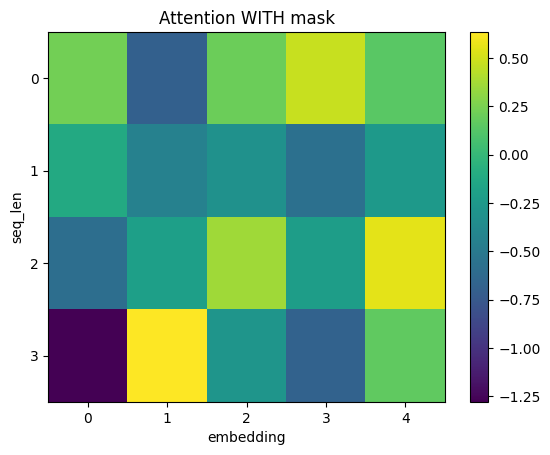

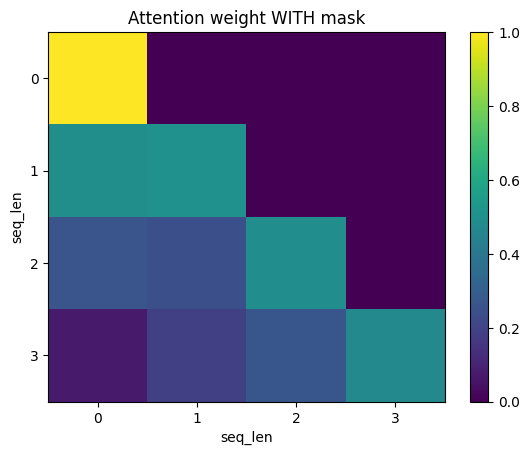

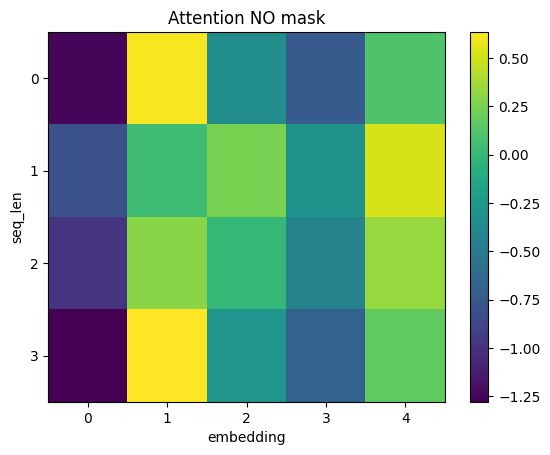

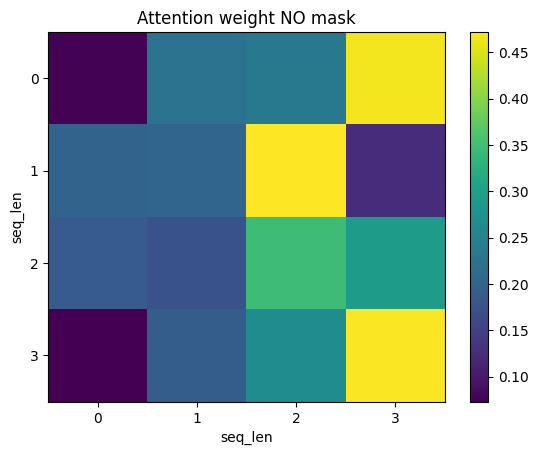

In [35]:
def display_matrix(m: torch.Tensor, title: str = "Matrix", x_label: str = "", y_label: str = ""):
    np_m = m.cpu().detach()

    plt.imshow(np_m, aspect="auto")
    plt.yticks(range(np_m.shape[0]), range(np_m.shape[0]))
    plt.xticks(range(np_m.shape[1]), range(np_m.shape[1]))
    plt.xlabel(x_label)  # Add name to the X-axis
    plt.ylabel(y_label)
    plt.colorbar()
    plt.title(title)
    plt.show()


display_matrix(attn[0][0], title="Attention WITH mask", x_label="embedding", y_label="seq_len")
display_matrix(attn_weight[0][0], title="Attention weight WITH mask", x_label="seq_len", y_label="seq_len")

display_matrix(attn_no_mask[0][0], title="Attention NO mask", x_label="embedding", y_label="seq_len")
display_matrix(attn_weight_no_mask[0][0], title="Attention weight NO mask", x_label="seq_len", y_label="seq_len")

In [0]:
#| echo: false
#| output: asis
show_doc(MultiHeadAttention)

---

### MultiHeadAttention

>      MultiHeadAttention (d:int, h:int, dropout:float=0.0, bias:bool=True)

*Multihead attention module as defined in Formal algorithm for transformers (https://arxiv.org/abs/2207.09238)
It can be used for different attention architectures like encoder-decoder/seq-to-seq (very first transformer),
encoder-only (bert), decoder-only (gpt-*, gopher).

It splits weights into h heads.*

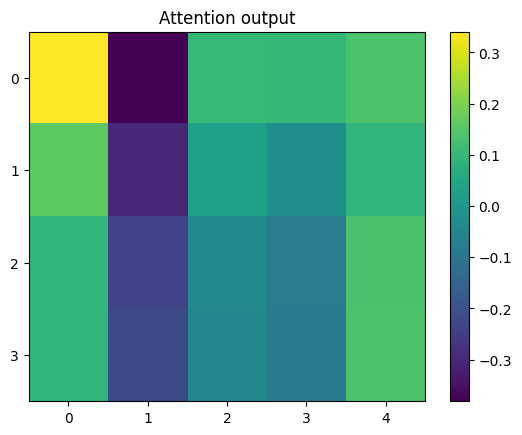

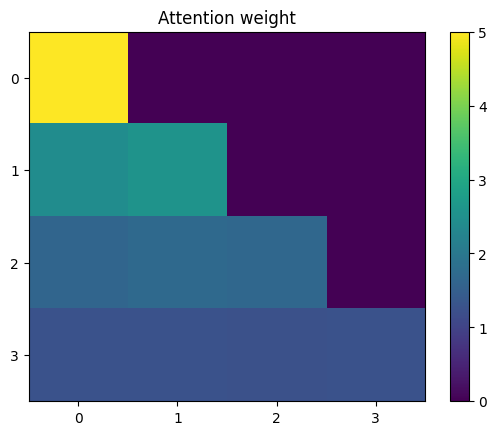

In [38]:
batch_size = 2
primary_seq = torch.rand((batch_size, seq_len, embedding_dim)).to(device)
ctx_seq = torch.rand((batch_size, seq_len, embedding_dim)).to(device)

mh = MultiHeadAttention(d=embedding_dim, h=5, dropout=0.0, bias=False).to(device)
mh_attn, mh_attn_weight = mh(primary_seq, ctx_seq, mask=mask)

display_matrix(mh_attn[0], title="Attention output")
display_matrix(mh_attn_weight[0], title="Attention weight")

In [39]:
mh_attn.shape

torch.Size([2, 4, 5])

### torch MultiheadAttention implementation

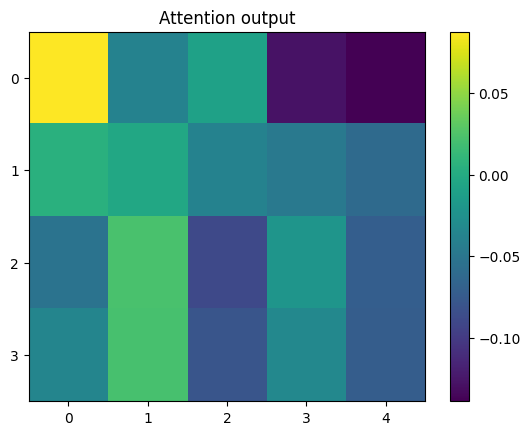

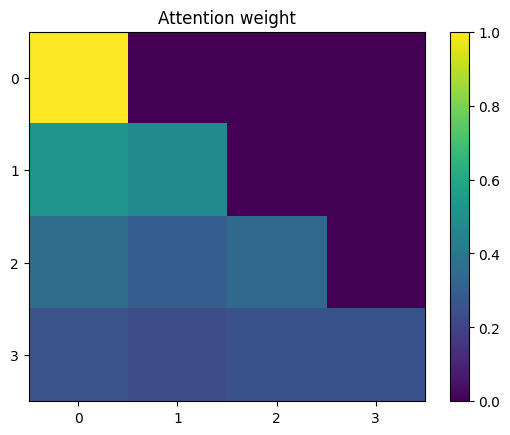

In [42]:
# test with multihead_attn = nn.MultiheadAttention(embed_dim, num_heads) so that result is the same.
# the graph output should look the same, even if they are not exactly the same due to different initialization

nn_mh = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=5, dropout=0.0, batch_first=True, bias=False).to(
    device
)
nn_mh_atn, nn_mh_atn_weights = nn_mh(primary_seq, ctx_seq, ctx_seq, attn_mask=mask[0] == 0)


display_matrix(nn_mh_atn[0], title="Attention output")
display_matrix(nn_mh_atn_weights[0], title="Attention weight")

## Layer normalization

My own implementation of layer normalization. To be compared with torch one.

In [0]:
#| echo: false
#| output: asis
show_doc(LayerNormalization)

---

### LayerNormalization

>      LayerNormalization (d:int, eps:float=1e-05)

*Base class for all neural network modules.

Your models should also subclass this class.

Modules can also contain other Modules, allowing to nest them in
a tree structure. You can assign the submodules as regular attributes::

    import torch.nn as nn
    import torch.nn.functional as F

    class Model(nn.Module):
        def __init__(self) -> None:
            super().__init__()
            self.conv1 = nn.Conv2d(1, 20, 5)
            self.conv2 = nn.Conv2d(20, 20, 5)

        def forward(self, x):
            x = F.relu(self.conv1(x))
            return F.relu(self.conv2(x))

Submodules assigned in this way will be registered, and will have their
parameters converted too when you call :meth:`to`, etc.

.. note::
    As per the example above, an ``__init__()`` call to the parent class
    must be made before assignment on the child.

:ivar training: Boolean represents whether this module is in training or
                evaluation mode.
:vartype training: bool*

In [44]:
# check implement is close to pytorch one.
torch.manual_seed(0)
x = torch.rand((batch_size, seq_len, embedding_dim)).to(device)
x = torch.tensor([[[2, 1, 1, 1, 1], [2, 2, 2, 2, 1]]], dtype=torch.float).to(device)
layer_norm = LayerNormalization(d=embedding_dim, eps=1e-05).to(device)
x_hat = layer_norm(x)

torch_x_hat = F.layer_norm(
    x, normalized_shape=[embedding_dim], weight=torch.ones(embedding_dim, dtype=torch.float, device=device), eps=1e-05
)
assert torch.allclose(x_hat, torch_x_hat), "my implementation and torch should be close"
x_hat, torch_x_hat

(tensor([[[ 1.9999, -0.5000, -0.5000, -0.5000, -0.5000],
          [ 0.5000,  0.5000,  0.5000,  0.5000, -1.9999]]], device='mps:0',
        grad_fn=<AddBackward0>),
 tensor([[[ 1.9999, -0.5000, -0.5000, -0.5000, -0.5000],
          [ 0.5000,  0.5000,  0.5000,  0.5000, -1.9999]]], device='mps:0'))

In [50]:
type(list(Q.size())[0])

int